# Cancer Data Logistic Regression (Student)

In [42]:
import pandas as pd
import os
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import chi2_contingency


Uncomment if you need the data files

In [44]:
# !wget https://aet-cs.github.io/white/ML/data/Cancer_Data.csv
# !wget https://aet-cs.github.io/white/ML/data/Cancer_Data_Cleaned.csv

In [45]:
data_root = "../data"
filename = "Cancer_Data.csv"
filepath = os.path.join(data_root, filename)
df = pd.read_csv(filepath)

In [46]:
def get_data(filename):
    df = pd.read_csv(filename)
    df.drop(['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'], axis=1, inplace=True)
    return df

In [47]:
df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [48]:
df.drop(['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'], axis=1, inplace=True)

In [49]:
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,NaN


In [50]:
def pre_process_data(df, one_hot_encode = False):
    # Use sklearn Imputers to fill in the categorical and numerical columns
    simple_median = SimpleImputer(strategy='median')
    simple_most_freq = SimpleImputer(strategy='most_frequent')

    num_cols = df.select_dtypes(include=np.number).columns # numerical data
    cat_cols = df.select_dtypes(include=object).columns # categorical data

    # Handle missing values
    df[num_cols] = simple_median.fit_transform(df[num_cols])
    df[cat_cols] = simple_most_freq.fit_transform(df[cat_cols])

    # Replace infinite values with NaN and then impute
    df = df.replace([np.inf, -np.inf], np.nan)
    df[num_cols] = simple_median.fit_transform(df[num_cols])

    if one_hot_encode:
        O_encoder = OrdinalEncoder()
        df[cat_cols]= O_encoder.fit_transform(df[cat_cols])

    return df

In [51]:
def get_test_train(df, test_size = 0.2, random_state = True):
    target = "diagnosis"
    X = df.drop(target, axis=1)

    # Robust scaling to handle outliers
    scaler = preprocessing.RobustScaler().fit(X)
    X = scaler.transform(X)

    # Additional check for any remaining infinite values
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    y = df[target]
    if random_state is True:
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

## Start Work Here

Replace lreg with LogisticRegression

In [89]:
# These lines would load the data locally
data_root = "../data"
filename = "cancer_data_cleaned.csv"
filepath = os.path.join(data_root, filename)

# Perform a logistic regression
df = get_data(filepath)
df = pre_process_data(df, one_hot_encode = True)
X_train, X_test, y_train, y_test = get_test_train(df, random_state = True)

# Create logistic regression with liblinear solver
lreg = LogisticRegression(
    C=1.0,
    solver='liblinear',  # Different solver that might be more stable
    max_iter=10000,
    tol=1e-4
)
model = lreg.fit(X_train, y_train)

In [90]:
X_test

array([[ 1.01687947e-03, -5.14705882e-02,  3.01953819e-01, ...,
        -3.90016763e-01, -2.33727811e-01, -3.15914489e-01],
       [ 9.70058199e-01, -3.35784314e-01, -5.66607460e-01, ...,
        -2.76960328e-01,  8.49112426e-01, -2.20902613e-01],
       [-6.35216079e-03, -5.93137255e-01,  4.45825933e-01, ...,
         4.31924008e-01,  3.04733728e-01,  8.50356295e-01],
       ...,
       [ 1.03314539e+00, -3.18627451e-02,  2.29129663e-01, ...,
        -9.62935370e-02, -5.65088757e-01,  3.30166271e-01],
       [-6.40566089e-03,  2.69607843e-02,  3.51687389e-01, ...,
         3.89085491e-01, -2.13017751e-01,  3.14726841e-01],
       [ 1.03318303e+00,  1.03676471e+00,  7.97513321e-01, ...,
         1.24231701e+00, -2.84023669e-01,  1.44299287e+00]],
      shape=(114, 11))

Get the model score

In [98]:
pred = lreg.predict(X_test[0:1])
print("Prediction for first sample:", pred[0])
print(f"Train accuracy  = {model.score(X_train, y_train):.3}")
print(f"Test  accuracy  = {model.score(X_test, y_test):.3}")

Prediction for first sample: 0.0
Train accuracy  = 0.954
Test  accuracy  = 0.912


/Users/pewhite/miniconda3/envs/ml_course/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/pewhite/miniconda3/envs/ml_course/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/pewhite/miniconda3/envs/ml_course/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/pewhite/miniconda3/envs/ml_course/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/pewhite/miniconda3/envs/ml_course/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/pewhite/miniconda3/envs/ml_course/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [99]:
# Get feature names from the original dataframe (excluding the target column)
feature_names = df.drop('diagnosis', axis=1).columns

# Create a DataFrame with feature names and their corresponding coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lreg.coef_[0],
    'Abs_Coefficient': abs(lreg.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("Model Coefficients (sorted by absolute value):")
print(coef_df)

print("\nIntercept:", lreg.intercept_[0])

Model Coefficients (sorted by absolute value):
                   Feature  Coefficient  Abs_Coefficient
2             texture_mean     1.636713         1.636713
4                area_mean     1.572632         1.572632
8      concave points_mean     1.327526         1.327526
1              radius_mean     1.268614         1.268614
5          smoothness_mean     1.183048         1.183048
7           concavity_mean     1.172168         1.172168
3           perimeter_mean     1.118497         1.118497
9            symmetry_mean     0.756705         0.756705
10  fractal_dimension_mean    -0.572531         0.572531
6         compactness_mean     0.055425         0.055425
0                       id    -0.020302         0.020302

Intercept: -2.1773708072712448


Quick snapshot of the confusion matrix (rows are truth  0/1 and cols are predictions 0/1). You can shift-tab on the parens the see the method signature)

In [93]:
confusion_matrix(y_pred = model.predict(X_test), y_true = y_test)

/Users/pewhite/miniconda3/envs/ml_course/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/pewhite/miniconda3/envs/ml_course/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/pewhite/miniconda3/envs/ml_course/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


array([[65,  4],
       [ 6, 39]])

We want to get the probabilites from X-test, NOT the classifications. So we want raw values in (0,1). Edit this cell

In [94]:
# Get predicted probabilities for the test data
# You need to **CHANGE THIS CODE** and return only a vector of the probabilities for class = 1, which is the second column
y_prob = model.predict_proba(X_test)[:,1]

/Users/pewhite/miniconda3/envs/ml_course/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/pewhite/miniconda3/envs/ml_course/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/pewhite/miniconda3/envs/ml_course/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


If we sort y_prob and y_test in the same order, then we can make a reasonable plot

In [95]:
# Sort the data for plotting
sorted_indices = np.argsort(y_prob)  ## argsort returns the indices ordered by the key values, so we can copy the sort order around
sorted_y_prob = y_prob[sorted_indices]
sorted_y_test = np.array(y_test)[sorted_indices]

Print the vector of sorted_y_prob and of sorted_y_test to verify the are generally increasing from 0 to 1

In [96]:
## Your code here
print(sorted_y_prob)
print(sorted_y_test)

[3.70049861e-05 1.13345780e-04 1.57821684e-04 1.99111694e-04
 2.56142663e-04 5.09224856e-04 6.11149678e-04 6.44653274e-04
 7.12425834e-04 1.52442583e-03 1.70695620e-03 1.74340598e-03
 1.92272428e-03 2.15930014e-03 2.47002039e-03 2.74297407e-03
 2.75913741e-03 4.21580908e-03 4.55374907e-03 4.77093781e-03
 5.24762144e-03 5.43758287e-03 5.80929587e-03 6.23347850e-03
 6.41023202e-03 8.24133406e-03 1.03131632e-02 1.14331798e-02
 1.26875063e-02 1.27915913e-02 1.28280859e-02 1.36392840e-02
 1.56584458e-02 1.60249062e-02 1.60430359e-02 1.66860012e-02
 1.83633019e-02 1.96284860e-02 2.09126376e-02 2.20866381e-02
 2.56793184e-02 2.57828382e-02 2.77986326e-02 2.86142357e-02
 2.98775344e-02 3.22777504e-02 3.45093251e-02 3.51471996e-02
 3.89416840e-02 4.20127110e-02 4.54293762e-02 4.78571743e-02
 4.96738583e-02 5.22706260e-02 5.86722668e-02 5.89833552e-02
 7.31814983e-02 8.62073124e-02 8.80361194e-02 1.83842632e-01
 1.84088372e-01 1.87346214e-01 1.94667620e-01 2.47518259e-01
 2.50740706e-01 2.523258

Now make a plot of a sigmoid curve against the 0/1 ground truth values. Fill in the code below as needed

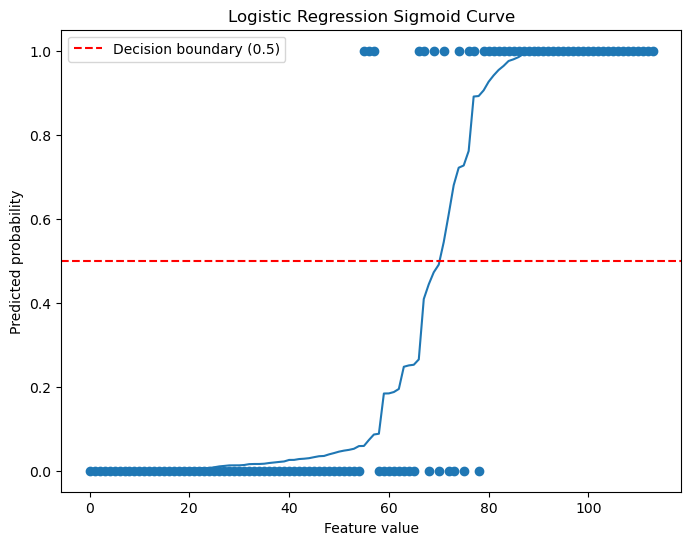

In [97]:
# Plot the sigmoid curve (predicted probabilities)
plt.figure(figsize=(8, 6))

# Plot the sorted_y_prob vector as a line, labeled "Predicted probability" in blue
plt.plot(sorted_y_prob)

# Plot the sorted_y_test values as a scatter plot, labeled "Actual Probability" in red
plt.scatter(range(len(sorted_y_test)), sorted_y_test)

# Plot the cutoff line (decision boundary at 0.5)
plt.axhline(0.5, color='red', linestyle='--', label='Decision boundary (0.5)')

plt.title('Logistic Regression Sigmoid Curve')
plt.xlabel('Feature value')
plt.ylabel('Predicted probability')
plt.legend()
plt.show()

Binary classification for logistic regression relies on knowing where the 'split point' is. It default to alpha = 0.5, but this may not be optimal. You will define some helper functions to determine an optimal alpha.

In [ ]:
def binary_classify(y_prob, alpha):
    # return a vector where index i is 1 if y_prob[i] > alpha, else 0

def tp(true, observed):
    # return the number of true positives, e.g. indices i where true[i] = observed[i] = 1

def tn(true, observed):
    return 0

def fp(true, observed):
    return 0

def fn(true, observed):
    return 0

def precision(true, observed):
    return 0

def recall(true, observed):
    return 0

def score(true, observed, weights):
    # return a weighted score of tp, fp, tn fn according to the weights
    tps, fps, tns, fns = weights
    return 0

IndentationError: expected an indented block after function definition on line 1 (3234477519.py, line 4)

Test your code works and get a high precision

In [18]:
observed = binary_classify(sorted_y_prob, 0.5)
q = zip(observed, sorted_y_test)
print(precision(sorted_y_test, observed))

NameError: name 'binary_classify' is not defined

Create a plot of recall vs precision for various alpha. Let alpha from from 0 to 100 in steps of 0.01. Compute the new classification, then the precision and recall score. Then plot a scatter plot
of (precision(alpha), recall(alpha)) points. Code is provided to plot the alphas along the graph.

IndexError: list index out of range

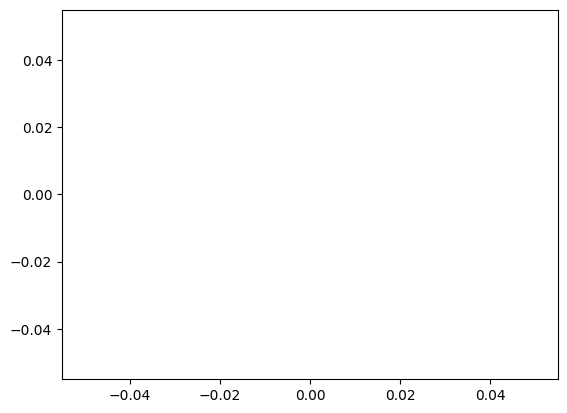

In [ ]:
ps = []
rs = []
for i in range(100):
    alpha = i/100.0
    # finish code

plt.plot(ps, rs)

# Don't edit the following, it makes labels. You can tweak it once you understand if you want
# Annotate alpha values at selected points (for example, every 10th point)
for i in range(0, 100, 10):  # You can change the step size (10) to select more/fewer points
    alpha = i / 100.0
    plt.annotate(f'α={alpha:.2f}', (ps[i], rs[i]),
                 textcoords="offset points", xytext=(5, -5), ha='center')
plt.grid()

Now we want to see how weighted scores vary as a function of alpha. Start with a score vector of (0,1,0,3) (why?)

In [20]:
ps = []
rs = []
scores = []
# code here

Now plot the scores and visually identify a minimum

In [21]:
## code here

Get the index of the lowest score and the lowest score itself

In [21]:
np.argmin(scores), np.min(scores)

ValueError: attempt to get argmin of an empty sequence

Properly define opt_alpha based on the scores vector

In [22]:
opt_alpha = ????
observed = binary_classify(sorted_y_prob, opt_alpha)
ps = precision(sorted_y_test, observed)
rs = recall(sorted_y_test, observed)
opt_tp = tp(sorted_y_test, observed)
opt_tn = tn(sorted_y_test, observed)
opt_fp = fp(sorted_y_test, observed)
opt_fn = fn(sorted_y_test, observed)

SyntaxError: invalid syntax (2845262698.py, line 1)

Make the following line nicer -- what are you printing? Give labels

In [23]:
print(ps, rs, opt_tp, opt_tn, opt_tp, opt_fn)

NameError: name 'opt_tp' is not defined

Now draw a nice confusion matrix. No need to edit the code. How do you interpret this? Change the weights above and redo a few times. What happens?

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(sorted_y_test, observed, labels=lreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lreg.classes_)
disp.plot()
plt.show()

NameError: name 'sorted_y_test' is not defined

In [29]:
print("Data shape:", df.shape)
print("\nData info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nData description:")
print(df.describe())

Data shape: (569, 12)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      569 non-null    float64
 1   diagnosis               569 non-null    object 
 2   radius_mean             569 non-null    float64
 3   texture_mean            569 non-null    float64
 4   perimeter_mean          569 non-null    float64
 5   area_mean               569 non-null    float64
 6   smoothness_mean         569 non-null    float64
 7   compactness_mean        569 non-null    float64
 8   concavity_mean          569 non-null    float64
 9   concave points_mean     569 non-null    float64
 10  symmetry_mean           569 non-null    float64
 11  fractal_dimension_mean  569 non-null    float64
dtypes: float64(11), object(1)
memory usage: 53.5+ KB
None

Missing values:
id                        0
diagnosis      

In [32]:
# Check for any remaining problematic values
print("Checking X_train for issues:")
print("Infinites:", np.isinf(X_train).sum())
print("NaNs:", np.isnan(X_train).sum())
print("\nValue ranges:")
print("Min:", X_train.min())
print("Max:", X_train.max())
print("\nFeature means:", X_train.mean(axis=0))

Checking X_train for issues:
Infinites: 0
NaNs: 0

Value ranges:
Min: -3.112084787919981
Max: 7.052629038753288

Feature means: [-0.01455546  0.00767167 -0.00343694  0.00658136  0.00556668 -0.0331878
 -0.00717481 -0.0108478   0.00041727 -0.03648918 -0.03166475]
